<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT22/blob/PeterTKovacs_lab7/PeterTKovacs_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 7: optimization methods**
**Péter Kovács**

# **Abstract**

In this lab assignment, we implement two widely known, standard methods for optimization: the gradient descent and Newton's method.





#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2022 Péter Kovács (ptkovacs@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files
import numpy as np
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt

# **Introduction**

Optimization problems arise in many walks of industry and business, practically everywhere where the output of the investigated process depends on several variables we control.

The ultimate truth of global optimizaton that there is no 'best method', the performance of algoritms depends on the function we optimize. Hence, there are numerous proposed strategies that come in even more numerous variants depending on the exact implementation details.

In this report, I implement the gradient descent and Newton's method, which both are based on approximating the optimized function locally by its Taylor-series and then taking a step in the 'best' direction that is dictated by the applied approximation.




# **Method**

### 1) Gradient descent

The idea is to use a first order approximation of the objective $f$, and such, take a step in the direction of the negative gradient, which is the 'direction of steepest descent'. 

$x_{k+1}= x_k - \alpha_k ∇ f (x_k)$

Here, the parameter $α_k$ is the step size, which can be a fixed positive number or determined by some linesearch method to ensure the amount of progress is optimal ot at least leads to decreasing objective.

Linesearch methods are a distinct disciplne by themselves. Without going into much detail, we use the Goldstein-rule for accepting an $α$ value. Let $g_k(α)=f(x_k-α ∇f(x_k)) $, then the criteria:

$g_k(α) \leq g_k(0)+α g_k'(0) \cdot \epsilon$

$g_k(α) \geq g_k(0)+α g_k'(0) \cdot (1-\epsilon)$,

 with $ 0<ϵ<\frac{1}{2} $ real parameter

This ensures that the step size is not too small but the objective decreases.



In [3]:
from theano.tensor.basic import xor
def goldstein_linesearch(g,dg_0,epsilon):
  """
  do binary search for step length and stop when the Goldstein criterion is satisfied
  the starting points will be 0 (left) and some \alpha_0 (right) which is chosen by the algorithm

  arguments: g - the function along the line we search
            dg_0 - the derivative of g at zero (supposed to be negative, since we step in a descent direction)
            epsilon - the parameter of the Goldstein test, 0<epsilon<0.5 is assumed
  returns: an alpha value satisfying the test
  """

  left=0
  right=1

  goldstein_1=lambda x: g(x)<=g(0)+x*dg_0*epsilon
  goldstein_2=lambda x: g(x)>=g(0)+x*dg_0*(1-epsilon)

  while(not goldstein_2(right)):
    right*=2
  
  # now, there is at least one acceptable point between right and left

  middle=0.5*(right+left)

  while(not(goldstein_1(middle) and goldstein_2(middle))):
    if(not goldstein_1(middle)): # go to left
      right=middle
      middle=0.5*(right+left)
    elif(not goldstein_2(middle)):
      left=middle
      middle=0.5*(right+left)

    # print(middle)

  return middle


def gradient_descent(f,df,x0,epsilon,tol,n_max=1e6):
  """
  gradient descent for f

  arguments: f - callable function
             df - gradient, callable
             x0 - starting point
             epsilon: epsilon for Goldstein search
             tol: stopping criterion for iteration: |df(x)| < tol
             n_max: number of maximal iterations 

  returns: endpoint 
  """
  x_list=[x0]


  x=x0
  i=0

  while(np.linalg.norm(df(*x))>tol and i<n_max):
    x=x-df(*x)*goldstein_linesearch(lambda a: f(*(x-a*df(*x))),
                                   -df(*x).dot(df(*x)),
                                   epsilon)
    i+=1
    x_list.append(x)
    print(np.linalg.norm(df(*x)))

  return x_list



In [4]:
def visualize(x,f):
  """
  function to visualize the objective and our progress
  
  """
  xx=np.linspace(min([i[0] for i in x])-3,max([i[0] for i in x])+3,num=100)
  yy=np.linspace(min([i[1] for i in x])-3,max([i[1] for i in x])+3,num=100)
  z=np.zeros((100,100),dtype=float)
  for i in range(100):
      for j in range(100):
          z[j,i]=f(xx[i],yy[j])



  plt.figure(figsize=(10,10))
  c=plt.contourf(xx,yy,z,levels=30)
  plt.colorbar(c)
  plt.plot([i[0] for i in x],[i[1] for i in x],'-o',c='m')
  plt.xlabel('x')
  plt.ylabel('y')



In [5]:
def visualize_vec(x,f):
  """
  function to visualize the objective and our progress
  
  """
  xx=np.linspace(min([i[0] for i in x])-3,max([i[0] for i in x])+3,num=100)
  yy=np.linspace(min([i[1] for i in x])-3,max([i[1] for i in x])+3,num=100)
  z=np.zeros((100,100),dtype=float)
  for i in range(100):
      for j in range(100):
          z[j,i]=f(np.array([xx[i],yy[j]]))



  plt.figure(figsize=(10,10))
  c=plt.contourf(xx,yy,z,levels=30)
  plt.colorbar(c)
  plt.plot([i[0] for i in x],[i[1] for i in x],'-o',c='m')
  plt.xlabel('x')
  plt.ylabel('y')

#### tests

We test with a quadratic and a 'power four' function.
Since determining the exact solution only works for the quadratic case (it is unique then), we inspect convergence on a contour plot showing the values of the objective and our progress.

During optomization, the norm of the gradients is printed

$f_1(x,y)=3x^2+4y^2-xy-3x+4y$

In [6]:
xx=tt.dscalar()
yy=tt.dscalar()
zz=3*xx**2+4*yy**2-xx*yy-3*xx+4*yy
dzz=tt.grad(zz,[xx,yy])

f=theano.function([xx,yy],zz)
df=theano.function([xx,yy],dzz)

x=gradient_descent(f,lambda y,z: np.array(df(y,z)),np.array([10.,10.]),0.3,0.02)

21.806320757982075
6.5347814914215
2.594423505365944
1.0399418601877706
0.3099969036578316
0.12320980381082763
0.03707671237753387
0.014707477774870983


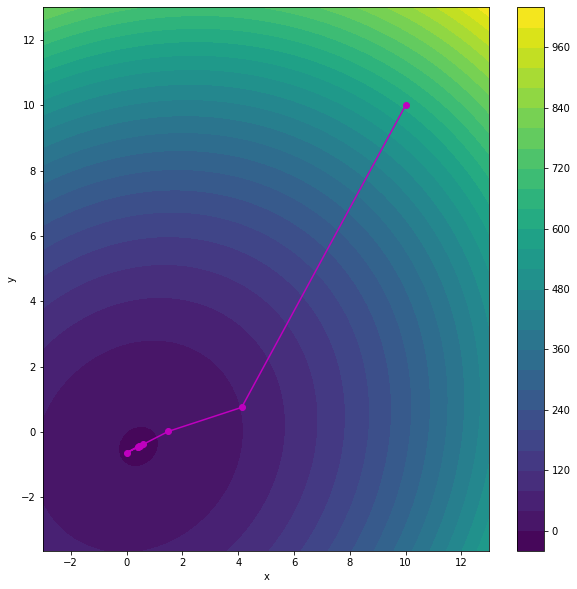

In [7]:
visualize(x,f)

$f_2(x,y)=3x^4+8y^2-8x^2y-5x+4y$

In [8]:
xx=tt.dscalar()
yy=tt.dscalar()
zz=3*xx**4+8*yy**2-8*xx**2*yy-5*xx+4*yy
dzz=tt.grad(zz,[xx,yy])

f=theano.function([xx,yy],zz)
df=theano.function([xx,yy],dzz)

x=gradient_descent(f,lambda y,z: np.array(df(y,z)),np.array([1.,10.]),0.3,0.02)

312.8037701993608
81.68834186065986
67.5583897457515
57.87351474651341
45.80345140782891
39.022544482020855
56.86486138579476
39.07227744050052
57.09884827353569
32.96928947823386
40.13209140705817
23.97128611232214
37.12090960883563
18.06759559023886
44.19379394016793
9.96278625400586
6.661403139481448
4.671879093489574
5.930735127354561
2.7159198361253925
2.9433139919530626
1.1295053068516367
0.8729070990041011
0.7487841336929383
0.3428107379709682
0.0976626837850851
0.06055660185467535
0.021896928932757576
0.006882785669673134


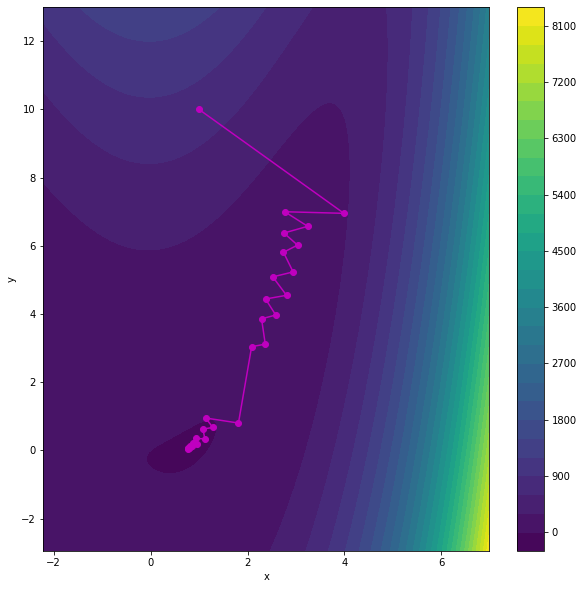

In [9]:
visualize(x,f)

As general remark, we can say that the gradient method works, but the speed of convergence indeed depends on the 'complexity' of the function we want to optimize.

For the second function, we can also observe a typical phenomenon associated with gradient methods: the 'zigzagging' behaviour.

I also remark, that the value of TOL indeed had a great impact on convergence. I observed cases when the method did not converge because at the end, a small gradient 'zigzag' prevented the method from terminating.

In conclusion, we can say that the vanilla GD may not be the best optimization method, but we cannot give a definitive verdict, since as usual, everything depends on the objective

### 2) Newton method

This method is based on the second order Taylor-series approximation of the objective function.

$f(x) ≈ f(x_k) + ∇f(x_k) (x-x_k) + \frac{1}{2} (x-x_k)^{T} f''(x_k) (x-x_k)$

It is easy to check that if the Hessian is positive definite, then the RHS is minimized by $x_{k+1}=x_k-(f''(x_k)^{-1} ∇f(x_k)$, which is indeed the update formula applied in the method

In [10]:
def newton_optimizer(df,Hf,x0,tol,n_max=10000):
  '''
  Newton optimizer for f(x), assuming that df,Hf are functions for the gradient of f and its Jacobian

  stopping criterion: |df(x)|<tol
  '''


  x_list=[x0]
  x=x0
  i=0

  while(np.linalg.norm(df(x))>tol and i<n_max):
    x=x-np.linalg.inv(Hf(x)).dot(df(x))
    i+=1
    x_list.append(x)
    print(np.linalg.norm(df(x)))

  return x_list




we use the second function from above:
$f_2(x,y)=3x^4+8y^2-8x^2y-5x+4y$

In [11]:

x=tt.dvector()
z=3*x[0]**4+8*x[1]**2-8*x[0]**2*x[1]-5*x[0]+4*x[1]
dz=tt.grad(z,x)
Hz=theano.gradient.hessian(z,x)


f=theano.function([x],z)
df=theano.function([x],dz)
Hf=theano.function([x],Hz)


x=newton_optimizer(df,Hf,np.array([1.,10.]),0.02)

3.352160904916733
0.8094517621624759
0.037386211755899186
0.00012068972569301964


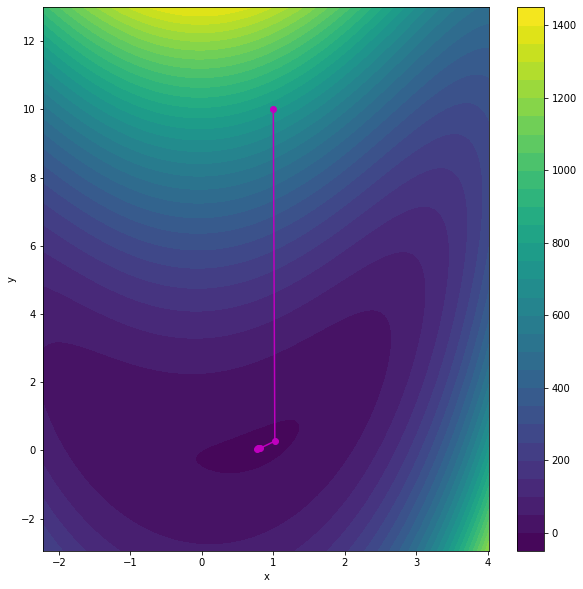

In [12]:
visualize_vec(x,f)

we can see that in our case, the Newton method is superior to gradient descent, but it scales poorly to higher dimensions, since it involves computing and inverting the Hessian

this may be the reason that gradient methods with some kind of momentum are very common in high dimensional optimization 


# **Summary, discussion**

Conclusions after each method.

It is very hard to make general comments on global optimization, since everything depends on the function we want to minimize.

It is the best to know multiple methods and actively supervise the optimization process